<a href="https://colab.research.google.com/github/AishwaryaParaspatki/Neural-Style-Transfer/blob/main/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


Define a function to load an image and limit its maximum dimension to 512 pixels.

In [5]:
def load_image(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels= 3) #Detects whether an image is a BMP, GIF, JPEG, or PNG, and performs the appropriate operation to convert the input bytes string into a Tensor of type dtype.
  img = tf.image.convert_image_dtype(img, tf.float32) #Convert image to dtype, scaling its values if needed.

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  
  plt.imshow(image)
  if title:
    plt.title(title)

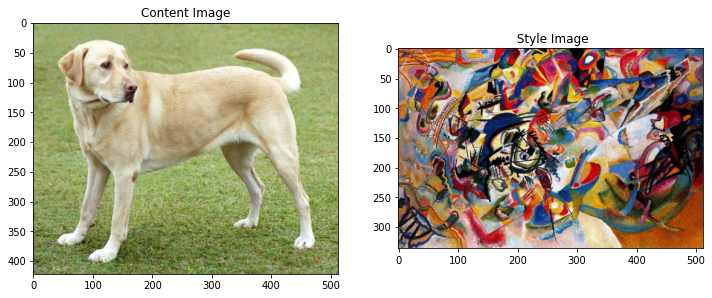

In [7]:
content_image = load_image(content_path)
style_image = load_image(style_path)

plt.subplot(1, 2, 1) #nrows, ncols, index
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, ' Style Image')

Fast Style Transfer using TF-Hub

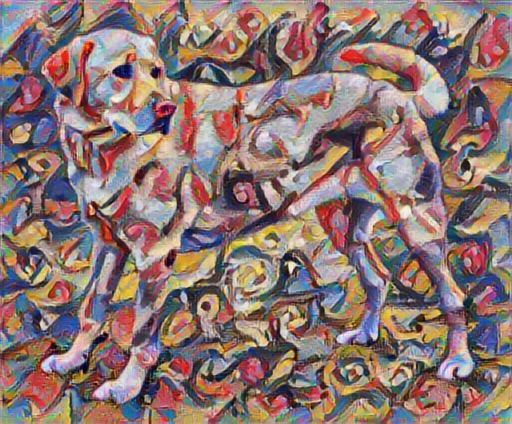

In [8]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
# tf.constant = Creates a constant tensor from a tensor-like object.
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

Define content and style representations.

Load a VGG19 and test run it on our image to ensure it's used correctly

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet') # include_top: whether to include the 3 fully-connected layers at the top of the network.
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 8s 0us/step


TensorShape([1, 1000])

In [10]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('Labrador_retriever', 0.4931726),
 ('golden_retriever', 0.23665206),
 ('kuvasz', 0.036357243),
 ('Chesapeake_Bay_retriever', 0.024182748),
 ('Greater_Swiss_Mountain_dog', 0.018646073)]

Load a VGG19 without the classification head, and list the layer names

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image

In [12]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

The networks in tf.keras.applications are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

model = Model(inputs, outputs)

This following function builds a VGG19 model that returns a list of intermediate layer outputs:


In [13]:
def vgg_layers(layer_names):
  # Creates a vgg model that returns a list of intermediate output values.
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)

  return model

In [14]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

#Statistics of each layers outputs
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("Shape: ", output.numpy().shape)
  print("Min: ", output.numpy().min())
  print("Max: ", output.numpy().max())
  print("Mean: ", output.numpy().mean())
  print()

block1_conv1
Shape:  (1, 336, 512, 64)
Min:  0.0
Max:  835.5255
Mean:  33.97525

block2_conv1
Shape:  (1, 168, 256, 128)
Min:  0.0
Max:  4625.887
Mean:  199.82687

block3_conv1
Shape:  (1, 84, 128, 256)
Min:  0.0
Max:  8789.24
Mean:  230.78099

block4_conv1
Shape:  (1, 42, 64, 512)
Min:  0.0
Max:  21566.135
Mean:  791.24005

block5_conv1
Shape:  (1, 21, 32, 512)
Min:  0.0
Max:  3189.2537
Mean:  59.179478



The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

Gcd = SUMij(Fijc(x), Fijd(x)) / IJ

This can be implemented concisely using the tf.linalg.einsum function:

In [15]:
def gram_matrix(input_tensor):
  '''Tensor contraction over specified indices and outer product.
  Einsum allows defining Tensors by defining their element-wise computation.
  This computation is defined by equation, a shorthand form based on Einstein
  summation.'''
  result = tf.linalg.einsum('bijc,bijd -> bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result / (num_locations)

Build a model that returns the style and content tensors.

In [16]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_inputs)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name:value
                    for content_name, value in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

When called on an image, this model returns the gram matrix (style) of the style_layers and content of the content_layers:

In [17]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, input in sorted(results['style'].items()):
  print(' ', name)
  print('Shape: ', output.numpy().shape)
  print('Min: ', output.numpy().min())
  print('Max: ', output.numpy().max())
  print('Mean: ', output.numpy().mean())
  print()

print('Contents:')
for name, input in sorted(results['content'].items()):
  print(' ', name)
  print('Shape: ', output.numpy().shape)
  print('Min: ', output.numpy().min())
  print('Max: ', output.numpy().max())
  print('Mean: ', output.numpy().mean())
  print()

Styles:
  block1_conv1
Shape:  (1, 21, 32, 512)
Min:  0.0
Max:  3189.2537
Mean:  59.179478

  block2_conv1
Shape:  (1, 21, 32, 512)
Min:  0.0
Max:  3189.2537
Mean:  59.179478

  block3_conv1
Shape:  (1, 21, 32, 512)
Min:  0.0
Max:  3189.2537
Mean:  59.179478

  block4_conv1
Shape:  (1, 21, 32, 512)
Min:  0.0
Max:  3189.2537
Mean:  59.179478

  block5_conv1
Shape:  (1, 21, 32, 512)
Min:  0.0
Max:  3189.2537
Mean:  59.179478

Contents:
  block5_conv2
Shape:  (1, 21, 32, 512)
Min:  0.0
Max:  3189.2537
Mean:  59.179478



Run gradient descent

In [18]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [19]:
image = tf.Variable(content_image)

In [20]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [21]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [22]:
style_weight = 1e-2
content_weight = 1e4

In [23]:
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers

  loss = style_loss + content_loss
  return loss

In [24]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
  
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

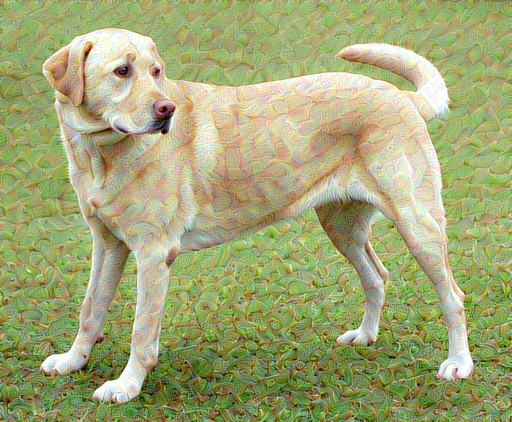

In [25]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

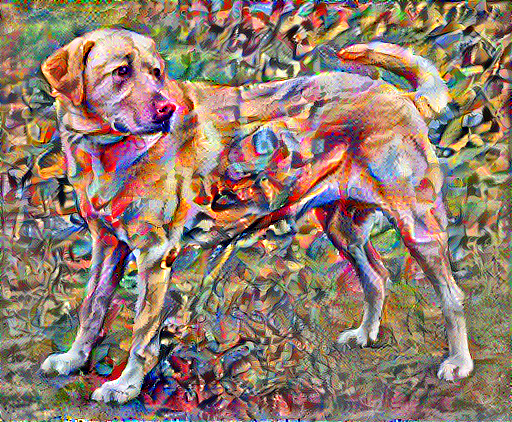

Train step: 1000
Total time: 6523.8


In [26]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print('.', end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Total Variation Loss

In [27]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

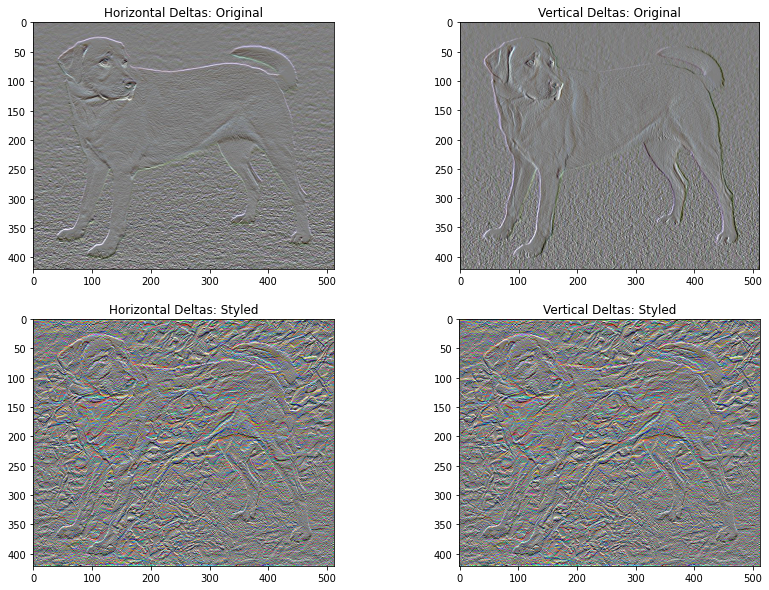

In [28]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize = (14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas + 0.5), 'Horizontal Deltas: Original')

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas + 0.5), 'Vertical Deltas: Original')

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas + 0.5), 'Horizontal Deltas: Styled')

plt.subplot(2,2,4)
imshow(clip_0_1(2*y_deltas + 0.5), 'Vertical Deltas: Styled')

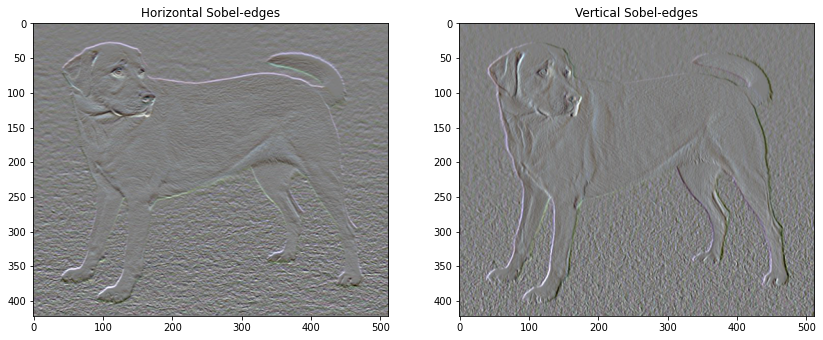

In [29]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0] / 4 + 0.5), 'Horizontal Sobel-edges')

plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1] / 4 + 0.5), 'Vertical Sobel-edges')

In [30]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [31]:
total_variation_loss(image).numpy()

149376.6

OR

In [32]:
tf.image.total_variation(image).numpy()

array([149376.6], dtype=float32)

Re-run the optimization

In [33]:
total_variation_weight = 30

In [34]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight * tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [35]:
image = tf.Variable(content_image)

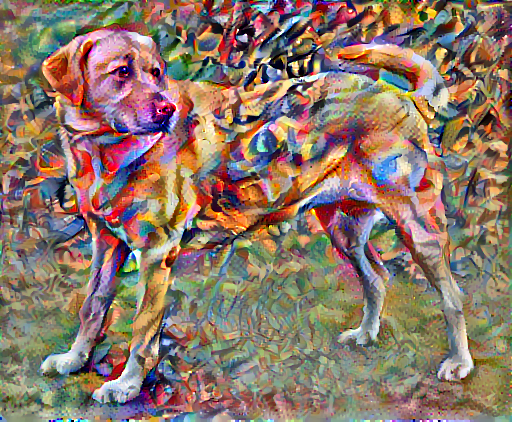

Train step: 1000
Total time: 6492.3


In [36]:
import time

start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print('.', end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print('Train step: {}'.format(step))

end = time.time()
print('Total time: {:.1f}'.format(end-start))

Save the final output

In [41]:
file_name = 'stylized_image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>